In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:  # Indentation corrected here
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/english-to-french/fra.txt


Encoder-decoder architectures can handle inputs and outputs that both consist of variable-length sequences and thus are suitable for sequence-to-sequence problems such as machine translation. The encoder takes a variable-length sequence as input and transforms it into a state with a fixed shape. The decoder maps the encoded state of a fixed shape to a variable-length sequence.

In [3]:
import torch
from torch import nn
import re
import collections
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F

lstm -- michigan slides end\
gru-- >\
-reset state - R(n,h)\
-update state - Z(n,h)\

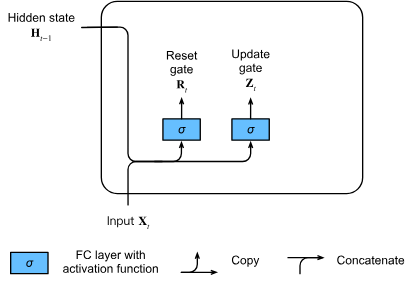

concat H_t-1 and X_t and pass it through reset gate(what to remove in the hidden state)\
also pass through the update gate (how much to keep of previous)

\begin{aligned}
   \mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xr}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hr}} + \mathbf{b}_\textrm{r}),\\
   \mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{\textrm{xz}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hz}} + \mathbf{b}_\textrm{z}),
   \end{aligned}

\begin{aligned}
{\mathbf{\tilde {H}}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\textrm{hh}} + \mathbf{b}_\textrm{h})
\end{aligned}

R_t multiplies element wise with H_t-1 to weight(as to keep or discard) to get a candidate hidden state

$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t$

when update gate is close to 1 we retain more of the previous state

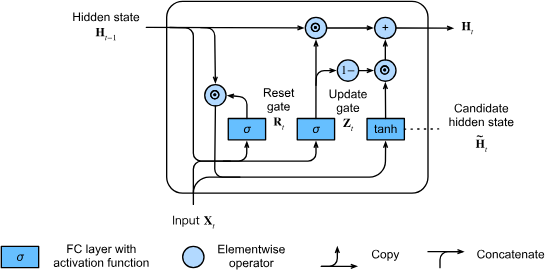

In [4]:
class GRUscrach(nn.Module):
    def __init__(self, input_size, hidden_size, sigma=0.01):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape)*sigma)
        triple = lambda: (init_weight(input_size, hidden_size),
                         init_weight(hidden_size, hidden_size),
                         nn.Parameter(torch.zeros(hidden_size)))
        self.W_xz ,self.W_hz , self.b_z = triple()
        self.W_xr, self.W_hr, self.b_r = triple()
        self.W_xh, self.W_hh, self.b_h = triple()
    
    def forward(self, inputs, H=None):
        T,B,C = inputs.shape
        if H is None:
            H = torch.zeros((B,self.hidden_size),
                            device=inputs.device)
        outputs = []
        for X in inputs:
            R = torch.sigmoid(X @ self.W_xr + H @ self.W_hr + self.b_r)
            Z = torch.sigmoid(X @ self.W_xz + H @ self.W_hz + self.b_z)
            H_tilde = torch.tanh(X @ self.W_xh + (R * H) @ self.W_hh +self.b_h)
            H = (1-Z) * H_tilde + Z * H
            outputs.append(H)
        return outputs, H

In [5]:
input_size = 10
hidden_size = 32
num_steps = 10
gru = GRUscrach(input_size,hidden_size)

In [6]:
%timeit out = gru.forward(torch.ones(num_steps,10,input_size))
rnn = nn.LSTM(input_size,hidden_size)
%timeit out = rnn.forward(torch.ones(num_steps,10,input_size))
gru = nn.GRU(input_size, hidden_size)
lst = gru(torch.ones(num_steps,10,input_size))
len(lst[0])
lst[1].shape
lst[0][0].shape

1.84 ms ± 48.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [296]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        #count token frequencies
        if tokens and isinstance(tokens[0],list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        
        #list of unique tokens
        self.itos = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.stoi = {token: idx for idx,token in enumerate(self.itos) }
        
    def __len__(self):
        #length of vocabulary
        return len(self.itos)
    
    def __getitem__(self, tokens):
        #make tokens into indices
        if not isinstance(tokens,(list,tuple)):
            return self.stoi.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        #make indixes into tokens
        if hasattr(indices,'__len__') and len(indices)>1:
            return [self.itos[int(index)] for index in indices]
        return slef.itos[indices]
    
    @property
    def unk(self):
        return self.stoi['<unk>']
class MTFraEng(nn.Module):
    def __init__(self, num_steps=9, num_train=512*4, num_val=128*4, train=True):
        super().__init__()
        
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        self.train = train
        #array and vocabs:
        self.arrays, self.src_vocab,self.target_vocab = self._build_arrays(self._load())
        
    def _load(self,path='/kaggle/input/english-to-french/fra.txt'):
        with open(path,"r",encoding='utf-8') as f:
            return f.read()
        
    def _preprocess(self, txt):
        txt = txt.replace('\u202f', ' ').replace('\xa0', ' ')
        out = ''
        for i,char in enumerate(txt):
            if char in ',.!?' and txt[i-1] != ' ':
                out += ' ' + char
            else:
                out += char
        return out.lower()
    
    def _tokenize(self, txt, max_examples=None):
        src,tgt = [],[]
        for i,row in enumerate(txt.split('\n')):
            if max_examples and i > max_examples:break
            split_ = row.split('\t')
            if len(split_) > 1:
                src.append(split_[0].split(' ') + ['<eos>'])
                tgt.append(split_[1].split(' ') + ['<eos>'])    
        return src,tgt
    
    def _build_array(self, sentences, vocab=None, is_tgt=False):
        pad_or_trim = lambda seq,max_len:(
        seq[:max_len] if len(seq) >= max_len else seq + ['<pad>']*(max_len-len(seq)))
        sentences = [pad_or_trim(s,self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.float32).sum(1)
        return array, vocab, valid_len
    
    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        src,tgt = self._tokenize(self._preprocess(raw_text),self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = self._build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = self._build_array(tgt, tgt_vocab, is_tgt=True)
        if self.train:
            return ((src_array[:self.num_train], tgt_array[:,:-1][:self.num_train], src_valid_len[:self.num_train], tgt_array[:,1:][:self.num_train]),
                   src_vocab,tgt_vocab)
        else:
            return ((src_array[self.num_train:self.num_train + self.num_val], tgt_array[:,:-1][self.num_train:self.num_train + self.num_val], \
                     src_valid_len[self.num_train:self.num_train + self.num_val], tgt_array[:,1:][self.num_train:self.num_train + self.num_val]),
                   src_vocab,tgt_vocab)
        
    def build(self, src_sentences, tgt_sentences):
        raw_text = '\n'.join([src + '\t' + tgt for src,tgt in zip(src_sentences,tgt_sentences)])
        arrays,_,_ = self._build_arrays(raw_text, self.src_vocab, self.target_vocab)
        return arrays
    def __getitem__(self,index):
        return self.arrays[0][index],self.arrays[1][index],self.arrays[2][index],self.arrays[3][index]
    
    def __len__(self):
        return self.arrays[0].shape[0]

In [297]:
data = MTFraEng(train=True)

In [300]:
print(data.src_vocab.itos[:40])

['!', '"aah', ',', '.', '."', '8:30', '<eos>', '<pad>', '<unk>', '?', 'a', 'aboard', 'after', 'again', 'agree', 'ahead', 'aim', 'air', 'alert', 'alive', 'all', 'alone', 'along', 'am', 'amused', 'angry', 'answer', 'anyone', 'are', 'armed', 'around', 'aside', 'ask', 'at', 'attack', 'awake', 'away', 'awesome', 'awful', 'back']


In [301]:
data._build_array([['he','lost','his'],['there']],data.src_vocab)

(tensor([[187, 265, 202,   7,   7,   7,   7,   7,   7],
         [427,   7,   7,   7,   7,   7,   7,   7,   7]]),
 tensor([3., 1.]))

In [302]:
data.src_vocab.itos[187],\
data.src_vocab.itos[265],\
data.src_vocab.itos[202],\
data.src_vocab.itos[427]

('he', 'lost', 'his', 'there')

In [303]:
def init_seq2seq(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
        
class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embd_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embd_size)
        self.rnn = nn.GRU(embd_size, hidden_size,num_layers,dropout = dropout)
        self.apply(init_seq2seq)
    def forward(self,X,*args):
        embd = self.embedding(X.t().type(torch.int64))
        #the input is not one hot encoded
#         print(embd.shape)
        outputs, state = self.rnn(embd)
        
        return outputs, state

In [304]:
embd_size,hidden_size,num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab),embd_size, hidden_size, num_layers, dropout)

In [306]:
# encoder.rnn

In [307]:
for name,_ in encoder.named_parameters():
    print(name)

embedding.weight
rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1


In [308]:
train_dataloader = DataLoader(data, batch_size=128)
# val_dataloader = DataLoader(MTFraEng(train=False), batch_size=256)

In [309]:
len(data.src_vocab.itos)

503

In [310]:
# %debug
data.build(['go there'],[''])

(tensor([[172, 427,   6,   7,   7,   7,   7,   7,   7]]),
 tensor([[4, 7, 5, 6, 6, 6, 6, 6, 6]]),
 tensor([3.]),
 tensor([[7, 5, 6, 6, 6, 6, 6, 6, 6]]))

In [311]:
# data.src_vocab['<unk>']
# data.src_vocab.itos
# data.src_vocab.stoi['hello']
# vocab_size, embd_size, hidden_size = 10, 8, 16
# batch_size, num_steps =4,9
# encoder = Seq2SeqEncoder(vocab_size, embd_size, hidden_size)
# X = torch.zeros((batch_size, num_steps))
# enc_out, enc_state = encoder(X)
# enc_out.shape

In [312]:
class Seq2SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embd_size, hidden_Size, num_layers, gropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embd_size)
        self.rnn = nn.GRU(embd_size + hidden_size, hidden_size, num_layers, dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)
        
    def _init_state(self, enc_all_outputs, *args):
        return enc_all_outputs
    
    def forward(self, X, state):
        embd = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        
        context = enc_output[-1]
        
        context = context.repeat(embd.shape[0], 1, 1)
        
        embd_and_context = torch.cat([embd,context],dim=-1)
        outputs, hidden_state = self.rnn(embd_and_context, hidden_state)
        outputs = self.dense(outputs).transpose(0,1)
        return outputs,[enc_output, hidden_state]
        

In [180]:
# @d2l.add_to_class(d2l.EncoderDecoder)  #@save
# def predict_step(self, batch, device, num_steps,
#                  save_attention_weights=False):
#     batch = [a.to(device) for a in batch]
#     src, tgt, src_valid_len, _ = batch
#     enc_all_outputs = self.encoder(src, src_valid_len)
#     dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
#     outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
#     for _ in range(num_steps):
#         Y, dec_state = self.decoder(outputs[-1], dec_state)
#         outputs.append(Y.argmax(2))
#         # Save attention weights (to be covered later)
#         if save_attention_weights:
#             attention_weights.append(self.decoder.attention_weights)
#     return torch.cat(outputs[1:], 1), attention_weights

In [313]:
class EncoderDecoder(nn.Module):  
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder._init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]
    
    def predict(self, batch,eos_token,max_len=10):
        src,tgt,src_valid_len,_ = batch
        enc_all_outputs = self.encoder(src,src_valid_len)
        dec_state = self.decoder._init_state(enc_all_outputs,src_valid_len)
        outputs = [tgt[:,(0)].unsqueeze(1)]
#         print(outputs[0].shape)
        while(True):
            Y, dec_state = self.decoder(outputs[-1],dec_state)
            outputs.append(Y.argmax(2))
            if len(outputs) > max_len:break
        return outputs

In [182]:
# decoder = Seq2SeqDecoder(vocab_size, embd_size, hidden_size)
# state = decoder._init_state(encoder(X))
# dec_outputs, state = decoder(X, state)

In [314]:
sample = next(iter(train_dataloader))

In [316]:
# sample[1]

In [317]:
decoder = Seq2SeqDecoder(len(data.target_vocab), embd_size, hidden_size, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [318]:
model.predict(data.build(['i lost'],['']),data.target_vocab['<eos>'])

[tensor([[4]]),
 tensor([[109]]),
 tensor([[245]]),
 tensor([[179]]),
 tensor([[297]]),
 tensor([[179]]),
 tensor([[628]]),
 tensor([[449]]),
 tensor([[91]]),
 tensor([[355]]),
 tensor([[149]])]

In [319]:
# len(data.target_vocab.itos)

In [188]:
data.build(['i lost'],[''])

(tensor([[220, 265,   6,   7,   7,   7,   7,   7,   7]]),
 tensor([[6, 4, 5, 5, 5, 5, 5, 5]]),
 tensor([3.]),
 tensor([[4, 5, 5, 5, 5, 5, 5, 5]]))

In [189]:
model.encoder,model.decoder

(Seq2SeqEncoder(
   (embedding): Embedding(503, 256)
   (rnn): GRU(256, 256, num_layers=2, dropout=0.2)
 ),
 Seq2SeqDecoder(
   (embedding): Embedding(687, 256)
   (rnn): GRU(512, 256, num_layers=2, dropout=0.2)
   (dense): Linear(in_features=256, out_features=687, bias=True)
 ))

In [190]:
data.target_vocab['<pad>']

5

In [191]:
# F.cross_entropy(out,label)

In [192]:
# label.shape

In [193]:
def masked_loss(logits, labels,tgt_pad):
    probs = F.softmax(logits, dim=-1)
    loss = - torch.log(probs[range(probs.shape[0]),labels])
    mask = (labels != tgt_pad).type(torch.float32)
    
    return torch.mean(loss*mask)

In [194]:
# logits = torch.tensor([[-1,0,1],[-1,1,0]],dtype=torch.float32)
# label = torch.tensor([2,1])
# masked_loss(logits,label,1)

In [195]:
lr = 5e-3
num_epochs = 60

In [320]:
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)

In [321]:
tgt_pad = data.target_vocab['<pad>']
loss_ = []
for epoch in range(num_epochs):
    for i,sample in enumerate(train_dataloader):
        out = model(sample[0],sample[1])
        B,T,C = out.shape
        out = out.reshape(B*T,-1)
        label = sample[3]
        label = label.reshape(B*T,)
        optimizer.zero_grad()
        loss = masked_loss(out,label,tgt_pad)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1)
        optimizer.step()
        loss_.append(loss.detach().cpu())

In [322]:
import matplotlib.pyplot as plt

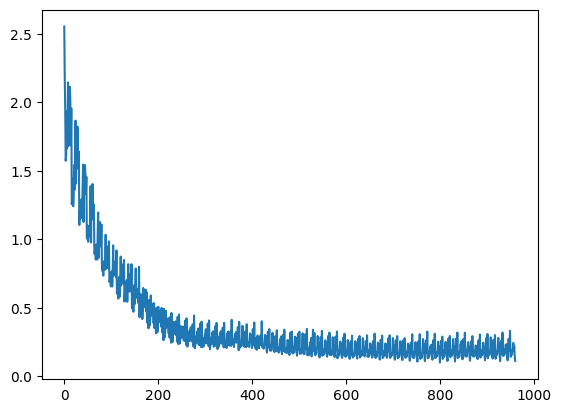

In [323]:
plt.plot(loss_)

In [324]:
loss.item()

0.11201116442680359

In [325]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

In [326]:
pred = model.predict(data.build(engs,fras),data.target_vocab['<eos>'])

In [327]:
data.build(engs,fras)

(tensor([[172,   3,   6,   7,   7,   7,   7,   7,   7],
         [220, 265,   3,   6,   7,   7,   7,   7,   7],
         [188,  64,   3,   6,   7,   7,   7,   7,   7],
         [223, 205,   3,   6,   7,   7,   7,   7,   7]]),
 tensor([[  4, 631,   0,   5,   6,   6,   6,   6,   6],
         [  4, 300, 441,   2,   5,   6,   6,   6,   6],
         [  4, 294, 223, 100,   2,   5,   6,   6,   6],
         [  4, 310, 577, 121, 386,   2,   5,   6,   6]]),
 tensor([3., 4., 4., 4.]),
 tensor([[631,   0,   5,   6,   6,   6,   6,   6,   6],
         [300, 441,   2,   5,   6,   6,   6,   6,   6],
         [294, 223, 100,   2,   5,   6,   6,   6,   6],
         [310, 577, 121, 386,   2,   5,   6,   6,   6]]))

In [328]:
data.target_vocab.itos[299]

"j'adore"

In [329]:
data.target_vocab.itos[4]

'<bos>'

In [339]:
str_ = ''
for i in range(4):
    for token in pred:
        str_ += data.target_vocab.itos[token[i].squeeze().item()] + ' '
    str_+='\n'

In [340]:
# pred

In [342]:
print(str_)

<bos> va ! <eos> ! <eos> ! <eos> ! <eos> ! 
<bos> j'ai perdu . <eos> . <eos> . <eos> . <eos> 
<bos> il est calme . <eos> . <eos> <eos> <eos> <eos> 
<bos> je suis chez moi . <eos> . <eos> . <eos> 



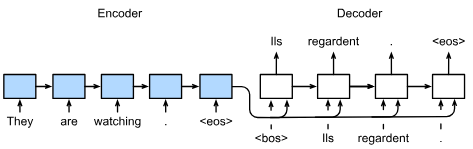

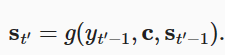

the decoder has a final state and all the outputs available and fed into the decoder(context and initial state)\
the context gets concatenated with the decoder inputs and trained just like a language model